# Feature selection

This notebook contains the simple examples of using feature extractor transforms with ETNA library.

### Navigation

- Into
- TreeFeatureSelectionTransform
- GaleShapleyFeatureSelectionTransform
- MRMRFeatureSelectionTransform


In [1]:
import warnings

warnings.filterwarnings("ignore")

## 1. Load Dataset

We are going to work with the time series from Tabular Playground Series - Jan 2022. The dataset contains daily merchandise sales – mugs, hats, and stickers – at two imaginary store chains across three Scandinavian countries. As exogenous data, we will use Finland, Norway, and Sweden Weather Data 2015-2019 dataset containing daily country average precipitation, snow depth and air temperature data.

In [2]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("data/nordic_merch_sales.csv")

In [3]:
from etna.datasets import TSDataset

df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

## 2. Feature selection methods

### 2.0 Intro to feature selection

ETNA provides several methods to drop unimportant features, let's look at each separately:

### 2.1 TreeFeatureSelectionTransform

This method use tree-based model to estimate importance of each feature. After that method leaves `top_k` best features:

In [4]:
from etna.transforms import TreeFeatureSelectionTransform, LagTransform, DateFlagsTransform
from sklearn.tree import DecisionTreeRegressor


transforms = [
    LagTransform(in_column="target", lags=range(10, 30), out_column="lag"),
    DateFlagsTransform(day_number_in_month=True, day_number_in_week=False,is_weekend=False, out_column="datetime_flag"),
]

model = DecisionTreeRegressor(random_state=42)

feature_selector_transform = TreeFeatureSelectionTransform(model=model, top_k=15)


Let's generate features:

In [5]:
ts.fit_transform(transforms=transforms)

ETNA also provides methods to plot importance of each feature:

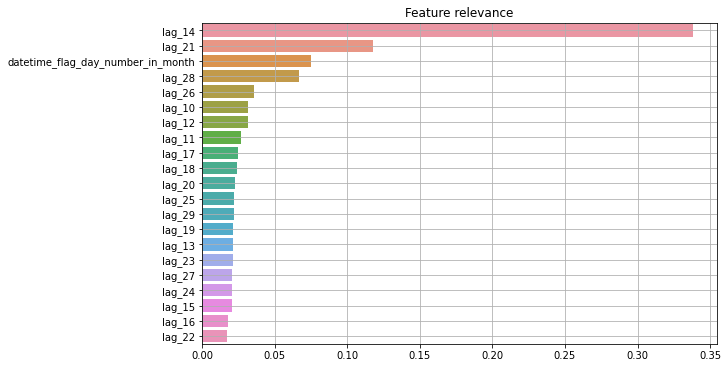

In [6]:
from etna.analysis import plot_feature_relevance
from etna.analysis.feature_relevance import RelevanceTable, ModelRelevanceTable

plot_feature_relevance(ts, relevance_table=ModelRelevanceTable(), relevance_params={"model": model})

Let's try our feature selector:

In [7]:
ts.fit_transform(transforms=[feature_selector_transform])
{column[1] for column in ts.df.columns}

{'datetime_flag_day_number_in_month',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_16',
 'lag_17',
 'lag_19',
 'lag_21',
 'lag_22',
 'lag_24',
 'lag_26',
 'lag_27',
 'lag_28',
 'target'}

### 2.1 GaleShapleyFeatureSelectionTransform

GaleShapleyFeatureSelectionTransform provides feature filtering with Gale-Shapley matching algo according to relevance table. Let's look at example of usage:


In [8]:
from etna.transforms import GaleShapleyFeatureSelectionTransform
from etna.analysis.feature_relevance import StatisticsRelevanceTable

rt = StatisticsRelevanceTable()
feature_selector_transform = GaleShapleyFeatureSelectionTransform(top_k=10, relevance_table=rt)

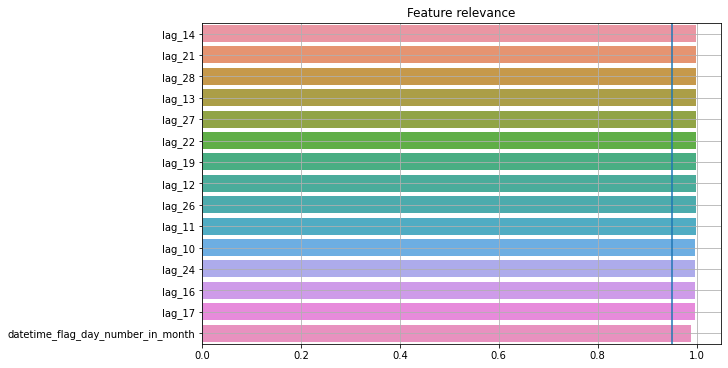

In [9]:
plot_feature_relevance(ts, relevance_table=rt)

In [10]:
ts.fit_transform(transforms=[feature_selector_transform])
{column[1] for column in ts.df.columns}

{'lag_12',
 'lag_13',
 'lag_14',
 'lag_16',
 'lag_17',
 'lag_21',
 'lag_22',
 'lag_26',
 'lag_27',
 'lag_28',
 'target'}

### 2.2 MRMRFeatureSelectionTransform

This algorithm iteratively finds best feature from non-selected features by some rule. This rule is to choose best feature $f$ by the next metric:

### $metic(f) = \frac{relevance(f | target)}{redundancy(f | previous)} = \frac{F(f, target)}{\sum_{s \in previous} |corr(f, s)|} \cdot (i-1)$

Where `previous` is previous selected features, `F` is F-statistic and `corr` is Pearson correlation, `i` is iteration.

Let's look at example of usage:

In [11]:
from etna.transforms.feature_selection import MRMRFeatureSelectionTransform

rt = StatisticsRelevanceTable()
feature_selector_transform = MRMRFeatureSelectionTransform(top_k=5, relevance_table=rt)

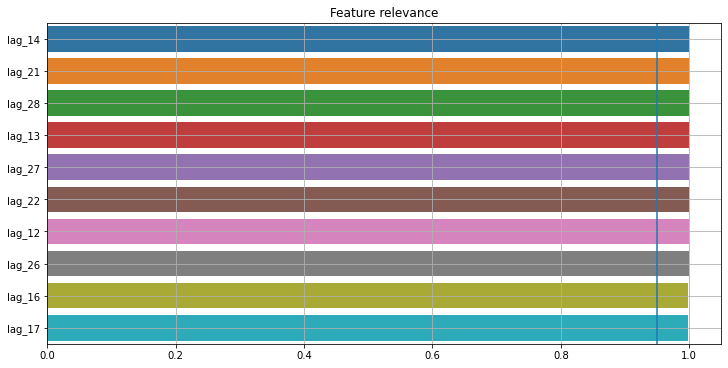

In [12]:
from etna.analysis import plot_feature_relevance
from etna.analysis.feature_relevance import RelevanceTable, ModelRelevanceTable


plot_feature_relevance(ts, relevance_table=rt, relevance_params={"model": model})

In [13]:
ts.fit_transform(transforms=[feature_selector_transform])
{column[1] for column in ts.df.columns}

{'lag_13', 'lag_14', 'lag_21', 'lag_27', 'lag_28', 'target'}